![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [67]:
from AlgorithmImports import *
import alphalens as al
import pandas as pd
from QuantConnect.Data.UniverseSelection import *
import pytz
import numpy as np

class FactorAnalysis:
    def __init__(self, qb, symbols, lookback_period=1500, rsi_period=3, adx_period=50, asset_class='forex'):
        self.qb = qb
        self.symbols = symbols
        self.lookback_period = lookback_period
        self.rsi_period = rsi_period
        self.adx_period = adx_period
        self.asset_class = asset_class
        self.history = self.qb.History([qb.AddForex(symbol).Symbol for symbol in symbols], lookback_period, Resolution.Daily)
        self.factors = self._calculate_combined_factors()

    def _symbol_to_str(self, symbol):
        return str(symbol).split()[0]

    def _calculate_rsi_factors(self):
        all_rsidf = []
        
        for symbol in self.symbols:
            rsi = RelativeStrengthIndex(self.rsi_period)
            rsidf = self.qb.Indicator(rsi, symbol, self.lookback_period, Resolution.Daily)
            rsidf['date'] = rsidf.index
            rsidf['asset'] = self._symbol_to_str(symbol)
            rsidf.reset_index(drop=True, inplace=True)
            rsidf.set_index(['date', 'asset'], inplace=True)
            all_rsidf.append(rsidf)
        
        combined_rsidf = pd.concat(all_rsidf)
        combined_rsidf.columns = ['averagegain', 'averageloss', 'current']
        combined_rsidf_reset = combined_rsidf.reset_index()
        combined_rsidf_reset['date'] = pd.to_datetime(combined_rsidf_reset['date']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        
        mean_rsi = combined_rsidf_reset['current'].mean()
        std_rsi = combined_rsidf_reset['current'].std()

        def transform_rsi(value):
            return ((100-value) - mean_rsi) / std_rsi

        combined_rsidf_reset['current'] = combined_rsidf_reset['current'].apply(transform_rsi)

        melted = pd.melt(combined_rsidf_reset, id_vars=['date', 'asset'], var_name='metric', value_name='value')
        pivot_df = melted.pivot_table(index=['date', 'asset'], columns='metric', values='value')
        pivot_df.columns.name = None
        pivot_df = pivot_df[['current']]
        pivot_df = pivot_df.reset_index().set_index(['date', 'asset'])
        pivot_df.sort_index(inplace=True)
        pivot_df = pivot_df[~pivot_df.index.duplicated(keep='first')]  # Remove duplicates
        return pivot_df

    def _calculate_adx_factors(self):
        all_adxdf = []
        
        for symbol in self.symbols:
            adx = AverageDirectionalIndex(self.adx_period)
            adxdf = self.qb.Indicator(adx, symbol, self.lookback_period, Resolution.Daily)
            adxdf['date'] = adxdf.index
            adxdf['asset'] = self._symbol_to_str(symbol)
            adxdf.reset_index(drop=True, inplace=True)
            adxdf.set_index(['date', 'asset'], inplace=True)
            all_adxdf.append(adxdf)
        
        combined_adxdf = pd.concat(all_adxdf)
        combined_adxdf.columns = ['adx', 'negativedirectionalindex', 'positivedirectionalindex']
        combined_adxdf_reset = combined_adxdf.reset_index()
        combined_adxdf_reset['date'] = pd.to_datetime(combined_adxdf_reset['date']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        
        mean_adx = combined_adxdf_reset['adx'].mean()
        std_adx = combined_adxdf_reset['adx'].std()

        def transform_adx(value):
            return (value - mean_adx) / std_adx

        combined_adxdf_reset['adx'] = combined_adxdf_reset['adx'].apply(transform_adx)

        melted = pd.melt(combined_adxdf_reset, id_vars=['date', 'asset'], var_name='metric', value_name='value')
        pivot_df = melted.pivot_table(index=['date', 'asset'], columns='metric', values='value')
        pivot_df.columns.name = None
        pivot_df = pivot_df[['adx']]
        pivot_df = pivot_df.reset_index().set_index(['date', 'asset'])
        pivot_df.sort_index(inplace=True)
        pivot_df = pivot_df[~pivot_df.index.duplicated(keep='first')]  # Remove duplicates
        return pivot_df

    def _calculate_combined_factors(self):
        rsi_factors = self._calculate_rsi_factors()
        adx_factors = self._calculate_adx_factors()

        combined_factors = pd.concat([rsi_factors, adx_factors], axis=1)
        combined_factors['combined'] = combined_factors['current'] + combined_factors['adx']
        return combined_factors[['combined']]

    def get_factors(self):
        return self.factors

    def get_prices(self):
        df = pd.DataFrame(self.history)
        df.reset_index(inplace=True)
        df['time'] = pd.to_datetime(df['time']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        df['symbol'] = df['symbol'].apply(self._symbol_to_str)
        df_wide = df.pivot(index='time', columns='symbol', values='close')
        df_wide = df_wide[~df_wide.index.duplicated(keep='first')]  # Remove duplicates
        prices = df_wide.loc[self.factors.index.get_level_values('date').unique()]
        return prices

    def get_clean_factor_and_forward_returns(self, max_loss=0.15, quantiles=5):
        prices = self.get_prices()
        factor_data = al.utils.get_clean_factor_and_forward_returns(self.factors, prices, max_loss=max_loss, quantiles=quantiles)

        # Filter to keep only quantiles 1 and 5
        factor_data = factor_data[factor_data['factor_quantile'].isin([1, 5])]
        return factor_data

# Example usage
qb = QuantBook()
symbols = ["EURUSD", "USDJPY", "GBPUSD", "USDCHF", "AUDUSD", "USDCAD", "NZDUSD"]
fa = FactorAnalysis(qb, symbols, asset_class='forex')

factors = fa.get_factors()
prices = fa.get_prices()
print(factors.head())
print(prices.head())
factor_data = fa.get_clean_factor_and_forward_returns()

print(factor_data.head())

al.tears.create_returns_tear_sheet(factor_data,
                                   long_short=True,
                                   group_neutral=False,
                                   by_group=False)


In [62]:
al.tears.create_information_tear_sheet(factor_data,
                                       group_neutral=False,
                                       by_group=False)

                                  combined
date                      asset           
2019-10-01 00:00:00+00:00 AUDUSD       NaN
                          EURUSD       NaN
                          GBPUSD       NaN
                          NZDUSD       NaN
                          USDCAD       NaN
symbol                       AUDUSD    EURUSD    GBPUSD    NZDUSD    USDCAD  \
date                                                                          
2019-10-01 00:00:00+00:00  0.670800  1.093405  1.229165  0.624315  1.321840   
2019-10-02 00:00:00+00:00  0.670825  1.096050  1.230430  0.626630  1.332885   
2019-10-03 00:00:00+00:00  0.674470  1.097455  1.234150  0.630305  1.333760   
2019-10-04 00:00:00+00:00  0.677000  1.097825  1.233290  0.631790  1.331220   
2019-10-06 00:00:00+00:00  0.676325  1.098345  1.233480  0.631585  1.330700   

symbol                       USDCHF    USDJPY  
date                                           
2019-10-01 00:00:00+00:00  0.992800  107.7480  
2

,1D,5D,10D
Ann. alpha,0.055,0.016,0.005
beta,-0.019,0.001,-0.016
Mean Period Wise Return Top Quantile (bps),1.833,0.467,0.299
Mean Period Wise Return Bottom Quantile (bps),-2.602,-0.800,-0.180
Mean Period Wise Spread (bps),4.435,1.275,0.486


<Figure size 640x480 with 0 Axes>

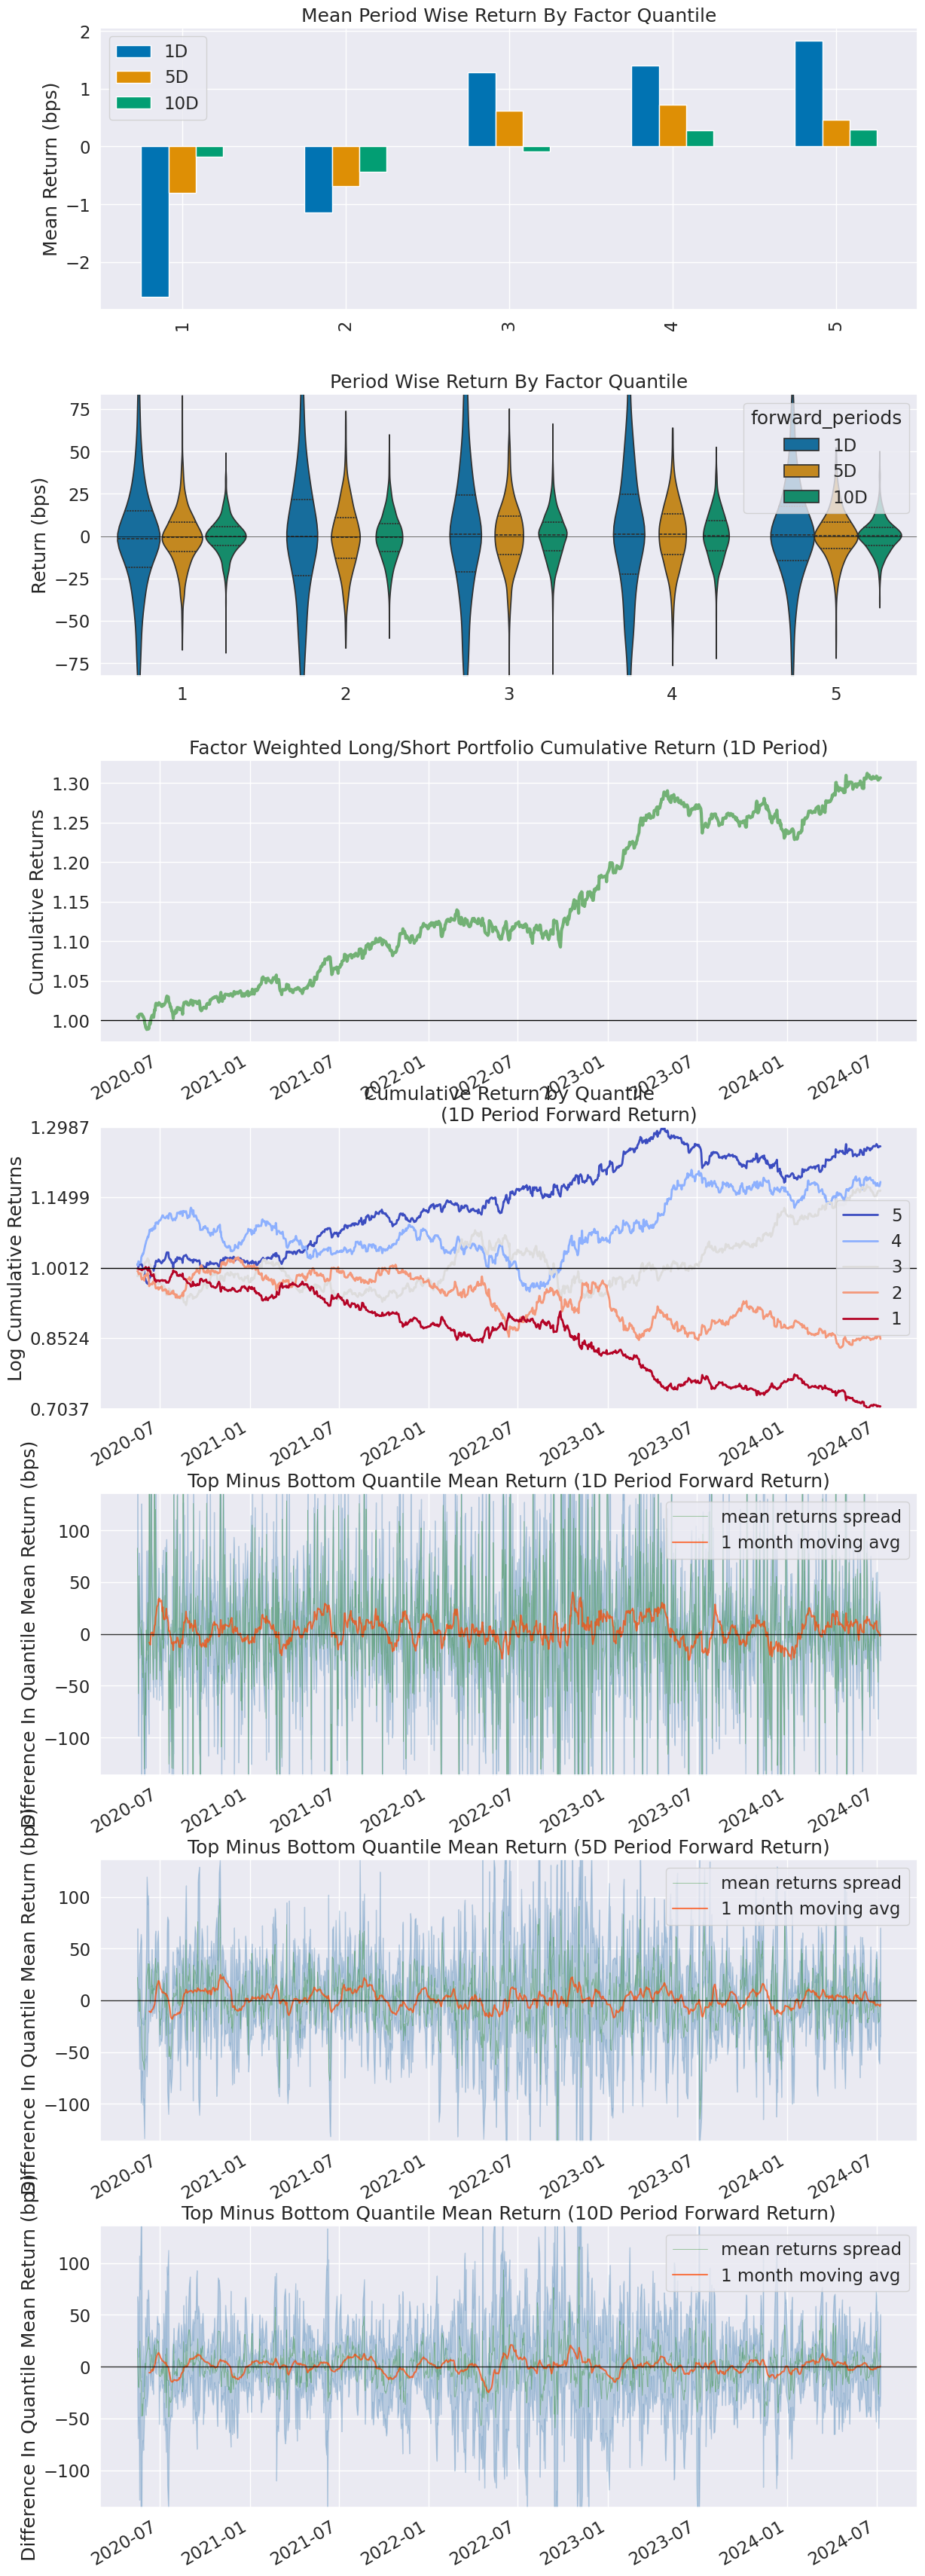

In [1]:
from AlgorithmImports import *
import alphalens as al
import pandas as pd
from QuantConnect.Data.UniverseSelection import *
import pytz
import numpy as np

class FactorAnalysis:
    def __init__(self, qb, symbols, lookback_period=1500, rsi_period=3, adx_period=100, asset_class='forex'):
        self.qb = qb
        self.symbols = symbols
        self.lookback_period = lookback_period
        self.rsi_period = rsi_period
        self.adx_period = adx_period
        self.asset_class = asset_class
        self.history = self.qb.History([qb.AddForex(symbol).Symbol for symbol in symbols], lookback_period, Resolution.Daily)
        self.factors = self._calculate_combined_factors()

    def _symbol_to_str(self, symbol):
        return str(symbol).split()[0]

    def _calculate_rsi_factors(self):
        all_rsidf = []
        
        for symbol in self.symbols:
            rsi = RelativeStrengthIndex(self.rsi_period)
            rsidf = self.qb.Indicator(rsi, symbol, self.lookback_period, Resolution.Daily)
            rsidf['date'] = rsidf.index
            rsidf['asset'] = self._symbol_to_str(symbol)
            rsidf.reset_index(drop=True, inplace=True)
            rsidf.set_index(['date', 'asset'], inplace=True)
            all_rsidf.append(rsidf)
        
        combined_rsidf = pd.concat(all_rsidf)
        combined_rsidf.columns = ['averagegain', 'averageloss', 'current']
        combined_rsidf_reset = combined_rsidf.reset_index()
        combined_rsidf_reset['date'] = pd.to_datetime(combined_rsidf_reset['date']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        
        mean_rsi = combined_rsidf_reset['current'].mean()
        std_rsi = combined_rsidf_reset['current'].std()

        def transform_rsi(value):
            return ((100-value) - mean_rsi) / std_rsi

        combined_rsidf_reset['current'] = combined_rsidf_reset['current'].apply(transform_rsi)

        melted = pd.melt(combined_rsidf_reset, id_vars=['date', 'asset'], var_name='metric', value_name='value')
        pivot_df = melted.pivot_table(index=['date', 'asset'], columns='metric', values='value')
        pivot_df.columns.name = None
        pivot_df = pivot_df[['current']]
        pivot_df = pivot_df.reset_index().set_index(['date', 'asset'])
        pivot_df.sort_index(inplace=True)
        pivot_df = pivot_df[~pivot_df.index.duplicated(keep='first')]  # Remove duplicates
        return pivot_df

    def _calculate_adx_factors(self):
        all_adxdf = []
        
        for symbol in self.symbols:
            adx = AverageDirectionalIndex(self.adx_period)
            adxdf = self.qb.Indicator(adx, symbol, self.lookback_period, Resolution.Daily)
            adxdf['date'] = adxdf.index
            adxdf['asset'] = self._symbol_to_str(symbol)
            adxdf.reset_index(drop=True, inplace=True)
            adxdf.set_index(['date', 'asset'], inplace=True)
            all_adxdf.append(adxdf)
        
        combined_adxdf = pd.concat(all_adxdf)
        combined_adxdf.columns = ['adx', 'negativedirectionalindex', 'positivedirectionalindex']
        combined_adxdf_reset = combined_adxdf.reset_index()
        combined_adxdf_reset['date'] = pd.to_datetime(combined_adxdf_reset['date']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        
        mean_adx = combined_adxdf_reset['adx'].mean()
        std_adx = combined_adxdf_reset['adx'].std()

        def transform_adx(value):
            return (value - mean_adx) / std_adx

        combined_adxdf_reset['adx'] = combined_adxdf_reset['adx'].apply(transform_adx)

        melted = pd.melt(combined_adxdf_reset, id_vars=['date', 'asset'], var_name='metric', value_name='value')
        pivot_df = melted.pivot_table(index=['date', 'asset'], columns='metric', values='value')
        pivot_df.columns.name = None
        pivot_df = pivot_df[['adx']]
        pivot_df = pivot_df.reset_index().set_index(['date', 'asset'])
        pivot_df.sort_index(inplace=True)
        pivot_df = pivot_df[~pivot_df.index.duplicated(keep='first')]  # Remove duplicates
        return pivot_df

    def _calculate_combined_factors(self):
        rsi_factors = self._calculate_rsi_factors()
        adx_factors = self._calculate_adx_factors()

        combined_factors = pd.concat([rsi_factors, adx_factors], axis=1)
        combined_factors['combined'] = combined_factors['current'] + combined_factors['adx']
        return combined_factors[['combined']]

    def get_factors(self):
        return self.factors

    def get_prices(self):
        df = pd.DataFrame(self.history)
        df.reset_index(inplace=True)
        df['time'] = pd.to_datetime(df['time']).dt.tz_localize('UTC').dt.normalize()  # Convert to date and localize
        df['symbol'] = df['symbol'].apply(self._symbol_to_str)
        df_wide = df.pivot(index='time', columns='symbol', values='close')
        df_wide = df_wide[~df_wide.index.duplicated(keep='first')]  # Remove duplicates
        prices = df_wide.loc[self.factors.index.get_level_values('date').unique()]
        return prices

    def get_clean_factor_and_forward_returns(self, max_loss=0.15, quantiles=5):
        prices = self.get_prices()
        factor_data = al.utils.get_clean_factor_and_forward_returns(self.factors, prices, max_loss=max_loss, quantiles=quantiles)

        # Filter to keep only quantiles 1 and 5
        return factor_data

# Example usage
qb = QuantBook()
symbols = ["EURUSD", "USDJPY", "GBPUSD", "USDCHF", "AUDUSD", "USDCAD", "NZDUSD"]
fa = FactorAnalysis(qb, symbols, asset_class='forex')

factors = fa.get_factors()
prices = fa.get_prices()
print(factors.head())
print(prices.head())
factor_data = fa.get_clean_factor_and_forward_returns()

print(factor_data.head())

al.tears.create_returns_tear_sheet(factor_data,
                                   long_short=True,
                                   group_neutral=False,
                                   by_group=False)


/opt/miniconda3/lib/python3.11/site-packages/alphalens/performance.py:1160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cumrets = cumrets.resample("1D").last().fillna(method="ffill")
/opt/miniconda3/lib/python3.11/site-packages/alphalens/utils.py:1009: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  return input + freq * days + offset
/opt/miniconda3/lib/python3.11/site-packages/alphalens/performance.py:1177: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  positions = positions.resample("1D").sum().fillna(method="ffill")
/opt/miniconda3/lib/python3.11/site-packages/alphalens/performance.py:1203: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_rets = benchmark_rets.resampl

Start date,2020-05-17
End date,2024-07-09
Total months,72
,Backtest
Annual return,5.22%
Cumulative returns,35.783%
Annual volatility,4.837%
Sharpe ratio,1.08
Calmar ratio,0.86
Stability,0.95
Max drawdown,-6.047%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.05,2023-05-02,2023-12-26,2024-04-30,261
1,3.80,2022-09-13,2022-09-26,2022-10-16,24
2,3.07,2020-07-16,2020-07-29,2020-10-12,63
3,3.00,2022-02-27,2022-05-29,2022-08-15,121
4,2.58,2021-02-24,2021-03-07,2021-05-04,50


/opt/miniconda3/lib/python3.11/site-packages/pyfolio/plotting.py:1373: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.boxplot(


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

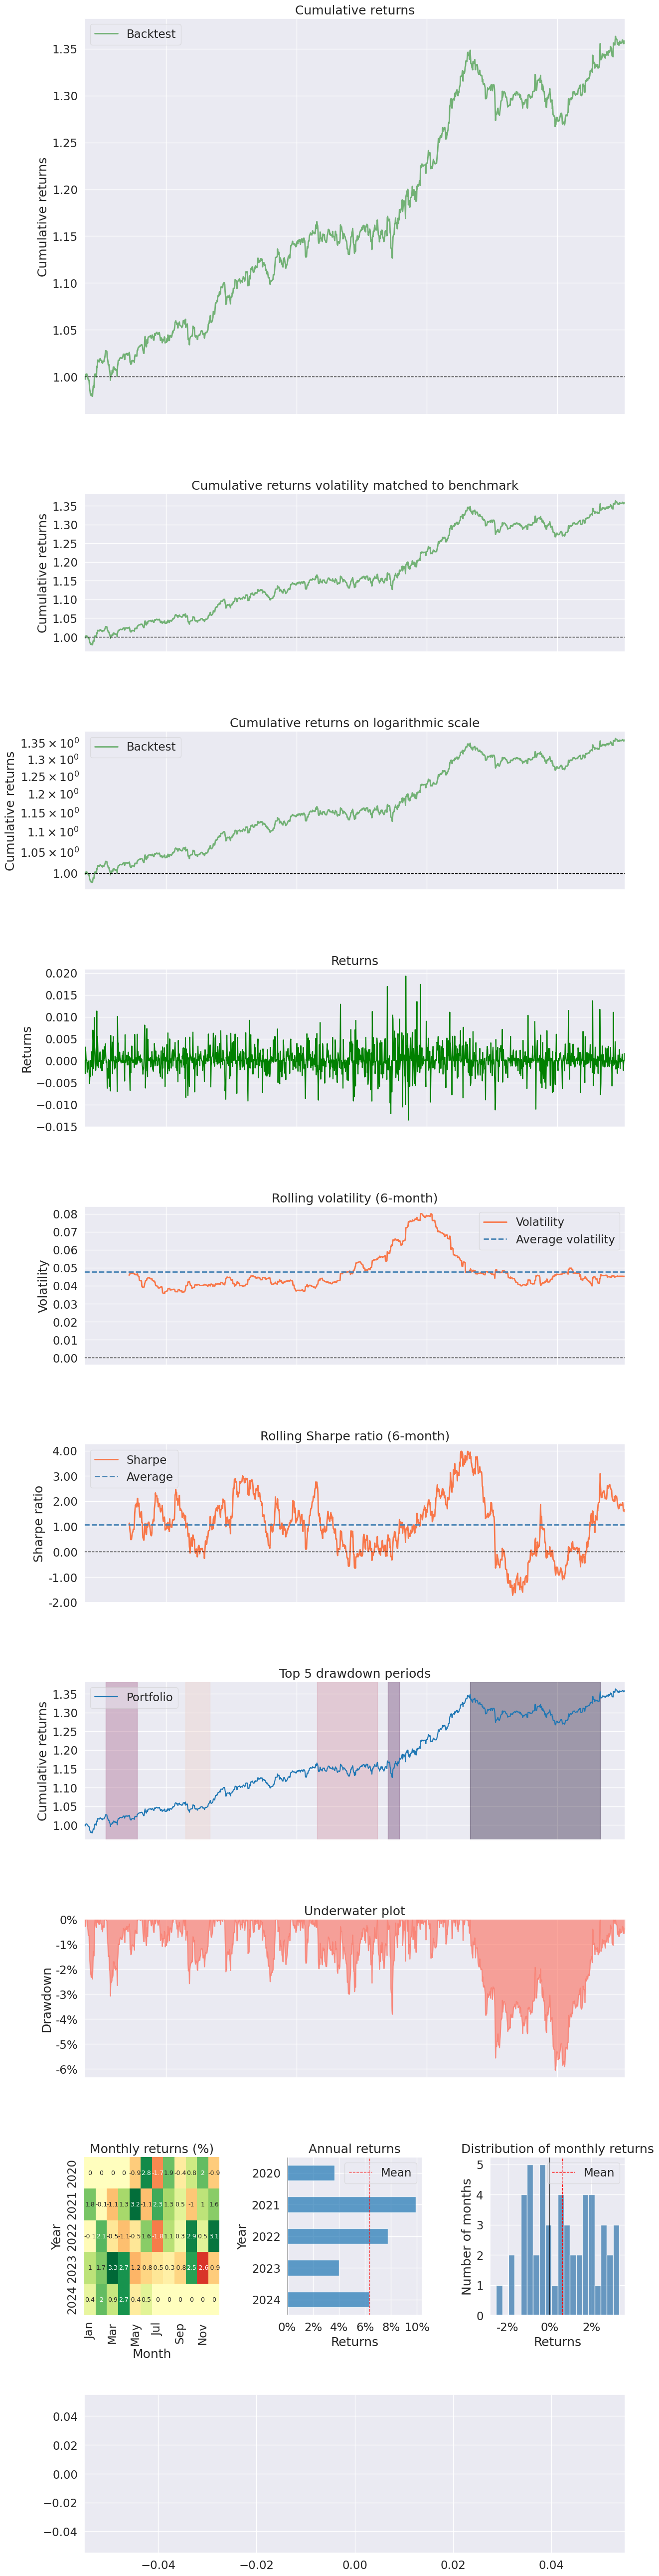

In [2]:
pf_returns, pf_positions, pf_benchmark = \
    al.performance.create_pyfolio_input(factor_data,
                                        period='1D',
                                        capital=10000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=False,
                                        quantiles=[1,5],
                                        groups=None,
                                        benchmark_period='1D')
import pyfolio as pf
pf.tears.create_full_tear_sheet(pf_returns,
                                positions=pf_positions,
                                #benchmark_rets=pf_benchmark, # optional, default to SPY
                                hide_positions=False)

In [5]:
pf_positions